# Skin Lesion Classification Training Pipeline (HAM10000)

## Definition:
-   This code builds and trains deep learning models to classify skin lesion images into 7 disease categories using the HAM10000 dataset.
It evaluates model performance using accuracy, confusion matrix, AUC, and classification reports, then saves the trained models.

In [1]:
import os
import pickle
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from dataset import HAM10000Dataset
from model import get_model
from train import train_model, evaluate

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("data/HAM10000_metadata (Copy).csv")
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)

train_df.to_csv("data/train.csv", index=False)
test_df.to_csv("data/test.csv", index=False)

train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])

train_dataset = HAM10000Dataset("data/train.csv", "data/images", train_transform)
test_dataset = HAM10000Dataset("data/test.csv", "data/images", test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

num_classes = 7
models_to_train = ["efficientnet", "resnet"]

os.makedirs("models", exist_ok=True)

for model_name in models_to_train:
    print(f"\nTraining {model_name}...")

    model = get_model(model_name, num_classes).to(device)

    train_acc, test_acc = train_model(model, train_loader, test_loader, epochs=2, device=device)

    acc, y_true, y_pred, y_prob = evaluate(model, test_loader, device)

    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob, multi_class='ovr')

    print("Confusion Matrix:\n", cm)
    print("AUC:", auc)
    print("Classification Report:\n", classification_report(y_true, y_pred))

    with open(f"models/{model_name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

    print(f"{model_name} model saved.")



Training efficientnet...
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /home/hassan/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


/home/hassan/Devalopment/Skin Cancer Model Training/.model/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hassan/Devalopment/Skin Cancer Model Training/.model/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100.0%


Epoch 1: Train Acc=0.6821 Test Acc=0.6970
Epoch 2: Train Acc=0.7752 Test Acc=0.7104
Confusion Matrix:
 [[1199    0   48    8   85    1    0]
 [  49    9   42    5  118    0    0]
 [  37    5  145    9   24    0    0]
 [  18    1   10   65    8    1    0]
 [   6    1    4    6    5    1    0]
 [   2   21   19   14    9    0    0]
 [   3    0    2    5    4   14    0]]
AUC: 0.8442817569589779
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1341
           1       0.24      0.04      0.07       223
           2       0.54      0.66      0.59       220
           3       0.58      0.63      0.60       103
           4       0.02      0.22      0.04        23
           5       0.00      0.00      0.00        65
           6       0.00      0.00      0.00        28

    accuracy                           0.71      2003
   macro avg       0.33      0.35      0.32      2003
weighted avg       0.73      0.71      0

/home/hassan/Devalopment/Skin Cancer Model Training/.model/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hassan/Devalopment/Skin Cancer Model Training/.model/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/hassan/Devalopment/Skin Cancer Model Training/.model/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/hassan/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100.0%


Epoch 1: Train Acc=0.7385 Test Acc=0.7474
Epoch 2: Train Acc=0.8014 Test Acc=0.7499
Confusion Matrix:
 [[1314    2    4   12    7    2    0]
 [ 103    1    7    5  106    0    1]
 [  64    7  108    7   34    0    0]
 [   9    2    4   78    9    0    1]
 [   3    1    1    3    1    0   14]
 [   8   24   11    8   13    0    1]
 [   3    0    0    4    1   20    0]]
AUC: 0.7510695202013778
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      1341
           1       0.03      0.00      0.01       223
           2       0.80      0.49      0.61       220
           3       0.67      0.76      0.71       103
           4       0.01      0.04      0.01        23
           5       0.00      0.00      0.00        65
           6       0.00      0.00      0.00        28

    accuracy                           0.75      2003
   macro avg       0.34      0.33      0.32      2003
weighted avg       0.71      0.75      0

# Calculating MCR, Specificity and Sensitivity

In [21]:
import os
import pickle
import tabulate
import torch
import pandas as pd
import numpy as np
from torchvision import transforms
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

from dataset import HAM10000Dataset  
from model import get_model          
from train import evaluate           


comparison=[]

for model_name in models_to_train:
    print(f"\nEvaluating {model_name}...")

    # Load trained model
    with open(f"models/{model_name}_model.pkl", "rb") as f:
        model = pickle.load(f)
    model.to(device)

    acc, y_true, y_pred, y_prob = evaluate(model, test_loader, device)

   
    cm = confusion_matrix(y_true, y_pred)
    try:
        auc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    except:
        auc = "N/A"

    mcr = 1 - acc
    sensitivity = recall_score(y_true, y_pred, average='macro')

    specificity_list = []
    for i in range(len(cm)):
        TP = cm[i,i]
        FP = cm[:,i].sum() - TP
        FN = cm[i,:].sum() - TP
        TN = cm.sum() - (TP + FP + FN)
        specificity_list.append(TN / (TN + FP))
    specificity = np.mean(specificity_list)

    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

 
    comparison.append({
        "Model": model_name,
        "Accuracy": round(acc,4),
        "MCR": round(mcr,4),
        "Sensitivity": round(sensitivity,4),
        "Specificity": round(specificity,4),
        "Precision": round(precision,4),
        "F1 Score": round(f1,4),
        "AUC": round(auc,4) if isinstance(auc,float) else auc
    })

comparison_df = pd.DataFrame(comparison)
print(tabulate.tabulate(comparison_df, headers='keys', tablefmt='grid'))


Evaluating efficientnet...

Evaluating resnet...
+----+--------------+------------+--------+---------------+---------------+-------------+------------+--------+
|    | Model        |   Accuracy |    MCR |   Sensitivity |   Specificity |   Precision |   F1 Score |    AUC |
+====+==============+============+========+===============+===============+=============+============+========+
|  0 | efficientnet |     0.7104 | 0.2896 |        0.3489 |        0.9402 |      0.3276 |     0.315  | 0.8443 |
+----+--------------+------------+--------+---------------+---------------+-------------+------------+--------+
|  1 | resnet       |     0.7499 | 0.2501 |        0.3251 |        0.9359 |      0.339  |     0.3228 | 0.7511 |
+----+--------------+------------+--------+---------------+---------------+-------------+------------+--------+


# Image Preprocessing
-   It shows how the Preprocessing effects the image

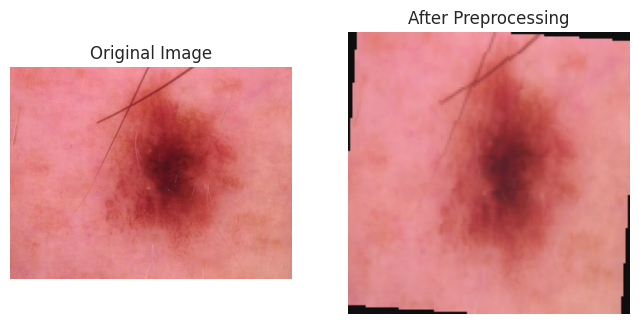

In [23]:
import matplotlib.pyplot as plt
from PIL import Image


img_path = "data/images/ISIC_0024306.jpg"  
img = Image.open(img_path)


preprocessed_img = train_transform(img)

preprocessed_img_np = preprocessed_img.permute(1,2,0).numpy()


plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(preprocessed_img_np)
plt.title("After Preprocessing")
plt.axis("off")
plt.show()


# Confusion Matrix Visuvalization

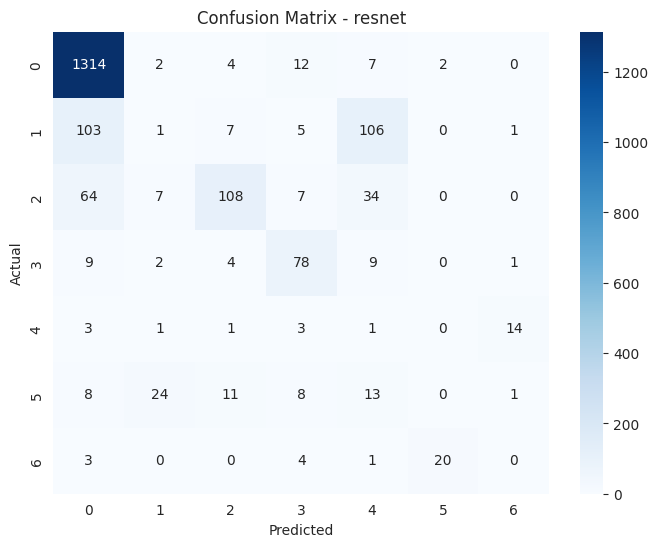

In [24]:
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


# ROC Curves for each class

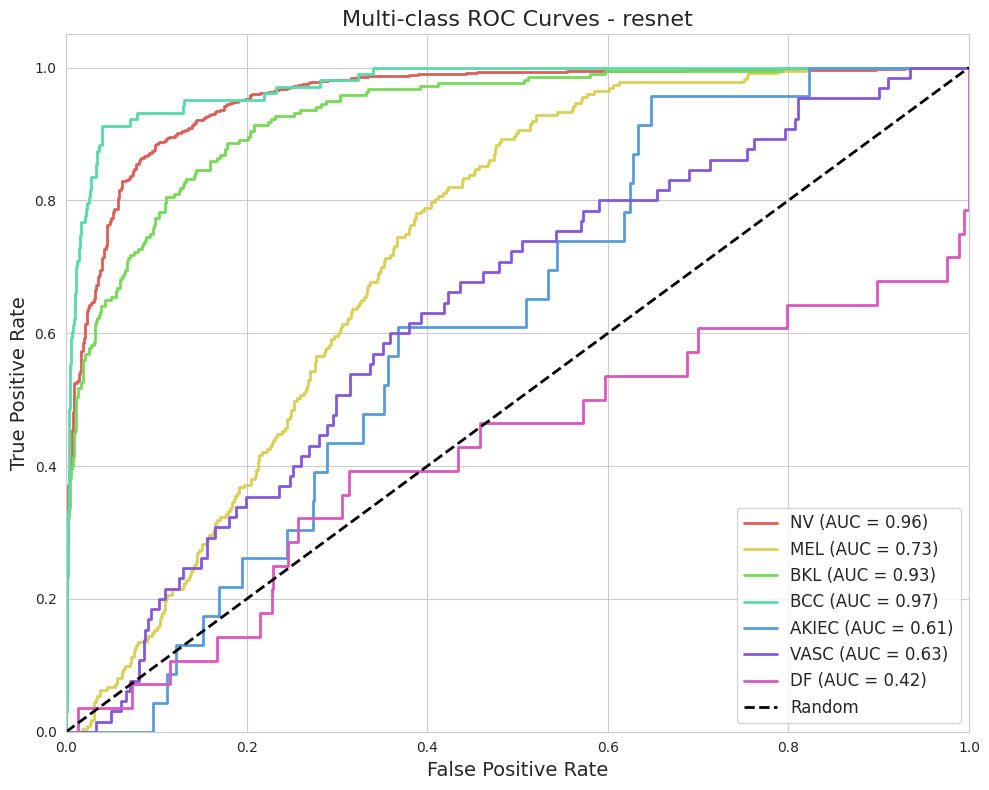

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns


class_names = ["NV", "MEL", "BKL", "BCC", "AKIEC", "VASC", "DF"]


y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

plt.figure(figsize=(10,8))
sns.set_style("whitegrid")  

colors = sns.color_palette("hls", num_classes) 

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:,i], y_prob[:,i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc:.2f})")


plt.plot([0,1], [0,1], 'k--', lw=2, label="Random")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title(f"Multi-class ROC Curves - {model_name}", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


# Class Distributon

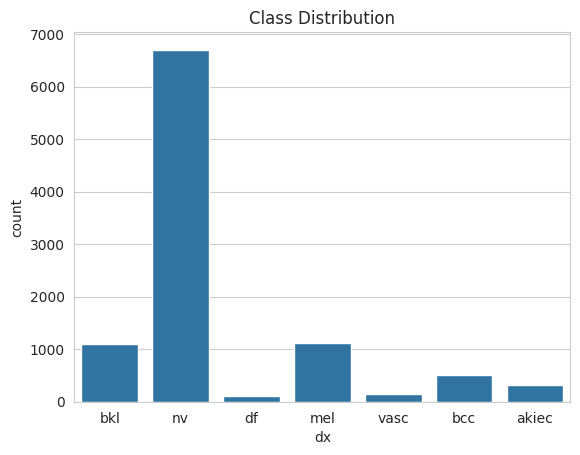

In [28]:
import seaborn as sns
sns.countplot(x="dx", data=df)
plt.title("Class Distribution")
plt.show()


# Missclacification Rate (Bar Plot)

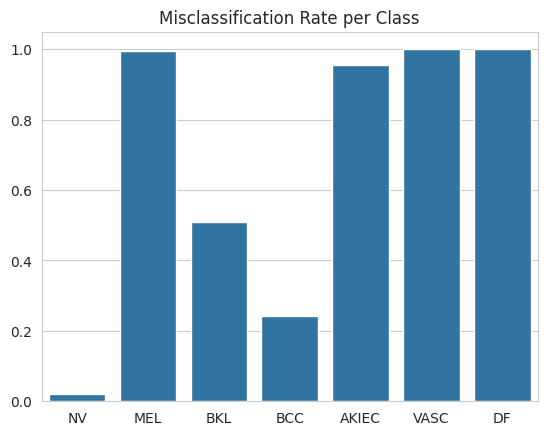

In [ ]:
mcr_per_class = 1 - np.diag(cm)/np.sum(cm, axis=1)
sns.barplot(x=class_names, y=mcr_per_class)
plt.title("Misclassification Rate per Class")
plt.show()


# Grad-CAM (Gradient-weighted Class Activation Mapping)
-   This code tell which part of the image is focused by the odel during prediction

In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image


def generate_gradcam(model, image_tensor, target_class):
    """
    model: trained CNN model
    image_tensor: input image tensor, shape [1, C, H, W]
    target_class: class index for which to generate heatmap
    """
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)


    target_layer = model.features[-1]  
    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    
    output = model(image_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()  
    score = output[0, target_class]

   
    model.zero_grad()
    score.backward()

    
    gradients_ = gradients[0].detach().cpu().numpy()[0]
    activations_ = activations[0].detach().cpu().numpy()[0]

    
    weights = np.mean(gradients_, axis=(1,2))

    
    cam = np.zeros(activations_.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * activations_[i]
    cam = np.maximum(cam, 0)
    cam = cam - np.min(cam)
    cam = cam / np.max(cam)  
    cam = np.uint8(cam * 255)
    cam = np.resize(cam, (image_tensor.shape[2], image_tensor.shape[3]))  

    return cam


/home/hassan/Devalopment/Skin Cancer Model Training/.model/lib/python3.12/site-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


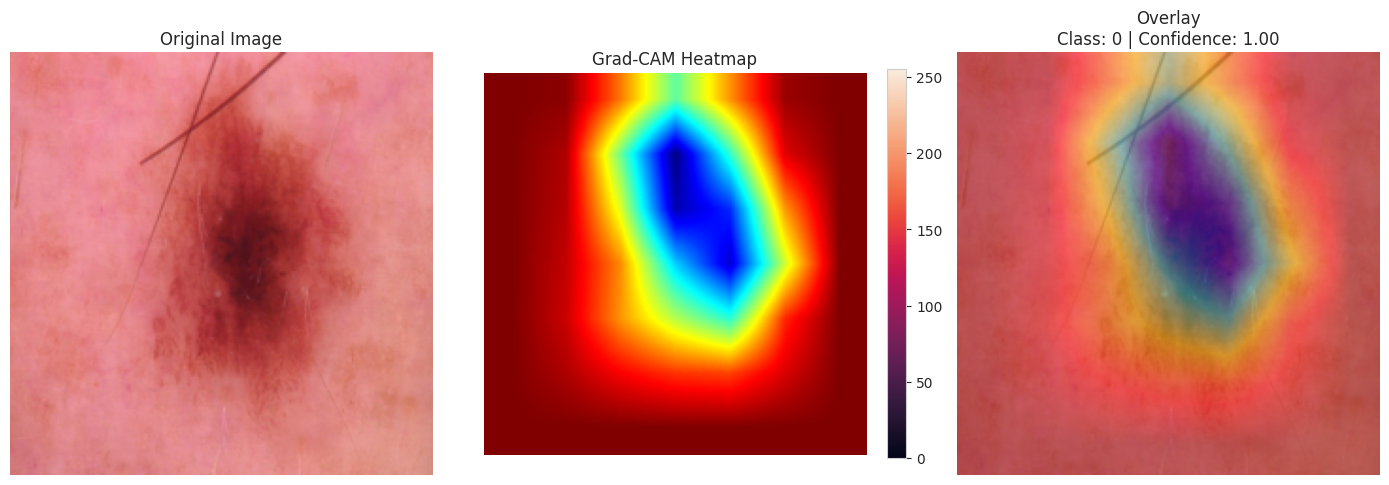

True

In [30]:

import cv2
from gradcam import GradCAM

with open("models/efficientnet_model.pkl", "rb") as f:
    model = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()


img_path = "data/images/ISIC_0024306.jpg"
img = Image.open(img_path).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),   # IMPORTANT: match training size
    transforms.ToTensor()
])

img_tensor = preprocess(img).unsqueeze(0).to(device)


if hasattr(model, "features"):           # EfficientNet
    target_layer = model.features[-1]
elif hasattr(model, "layer4"):           # ResNet
    target_layer = model.layer4[-1]
else:
    raise ValueError("Unsupported model architecture")


gradcam = GradCAM(model, target_layer)


with torch.no_grad():
    outputs = model(img_tensor)
    pred_class = outputs.argmax(dim=1).item()
    confidence = torch.softmax(outputs, dim=1)[0, pred_class].item()


cam = gradcam.generate(img_tensor, class_idx=pred_class)


cam_resized = cv2.resize(cam, (224, 224))
cam_resized = np.uint8(255 * cam_resized)


heatmap = cv2.applyColorMap(cam_resized, cv2.COLORMAP_JET)


img_resized = np.array(img.resize((224, 224)))


overlay = cv2.addWeighted(img_resized, 0.6, heatmap, 0.4, 0)


plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.imshow(img_resized)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.colorbar(fraction=0.046)
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(overlay)
plt.title(f"Overlay\nClass: {pred_class} | Confidence: {confidence:.2f}")
plt.axis("off")

plt.tight_layout()
plt.show()


cv2.imwrite("gradcam_heatmap.png", heatmap)
cv2.imwrite("gradcam_overlay.png", overlay)